In [53]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [54]:
sns.set(style="white")
sns.set_context("paper")

def figsize(scale,ratio, fig_width_pt = 505.69): # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    if(ratio == "golden"):                          # Golden ratio ...
        fig_height = fig_width*golden_mean          # height in inches
    else:                                           # ... or other ratio
        fig_height = fig_width*ratio
        
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {'backend': 'pdf',
                                            'axes.labelsize': 8,
                                            'xtick.labelsize': 8,
                                            'ytick.labelsize': 8,
                                            'legend.fontsize': 8,
                                            'lines.markersize': 3,
                                            'font.size': 8,
                                            'font.family': u'sans-serif',
                                            'font.sans-serif': ['Arial'],
                                            'text.usetex': False}
matplotlib.rcParams.update(pgf_with_latex)

In [55]:
def make_model_name(city, model_type, iterations=15000, dependent='ncrimes', spatial_name='ego'):
    model_name = '{city}_{spatial_name}_{name}_{iterations}_{dependent}'.format(iterations=iterations,
                                                                                city=city,
                                                                                name=model_type,
                                                                                dependent=dependent,
                                                                                spatial_name=spatial_name)
    return model_name

In [56]:
import pickle
import arviz as az

model_name = make_model_name('boston', 'uf')

# Load phi
with open('../data/generated_files/pkl/{spatial_model}_{model_name}.pkl'.format(spatial_model='BSF', model_name=model_name), "rb") as f:
    fit = pickle.load(f)['fit']
    la = fit.extract(permuted=False, inc_warmup=False, pars=['betas'])
    
    phi = la['betas'] # (n, chains, variables)
    percentiles = np.percentile(phi.mean(axis=1), [5, 50, 95], axis=0)
    

In [57]:
import pickle
import arviz as az

model_name = make_model_name('bogota', 'full')

# Load phi
with open('../data/generated_files/pkl/{spatial_model}_{model_name}.pkl'.format(spatial_model='BSF', model_name=model_name), "rb") as f:
    fit = pickle.load(f)['fit']
    la = fit.extract(permuted=False, inc_warmup=False, pars=['phi'])
    
    phi = la['phi'] # (n, chains, variables)
    percentiles = np.percentile(phi.mean(axis=1), [5, 95], axis=0)
    a = np.argwhere(((percentiles.T[:, 0] < 0) & (percentiles.T[:, 1] > 0)) | ((percentiles.T[:, 0] > 0) & (percentiles.T[:, 1] < 0))).flatten()
    #print(phi.shape)#np.sum(np.where(percentiles))
a

array([  0,   3,   4,  10,  11,  12,  19,  21,  22,  27,  28,  29,  30,
        32,  34,  37,  39,  40,  46,  47,  52,  53,  55,  56,  59,  65,
        67,  68,  69,  70,  76,  77,  78,  80,  81,  82,  85,  86,  87,
        88,  89,  90,  92,  93,  96,  97,  99, 100, 101, 103, 104, 107,
       108, 109, 110, 111, 112, 114])

In [58]:
def load_loo(model_name):
    with open('../data/generated_files/pkl/{spatial_model}_{model_name}.pkl'.format(spatial_model='BSF', model_name=model_name), "rb") as f:
        fit = pickle.load(f)['fit']

        data = az.from_pystan(posterior=fit,
                              observed_data=['y'],
                              log_likelihood='log_lik',
                              posterior_predictive='y_pred_full',
                              dims={'betas': ['features']})

        loo_result = az.loo(data, pointwise=True, scale='log').values
    return loo_result[6].values

In [59]:
cities = ['boston', 'bogota', 'LA', 'chicago'] #'bogota', 
couples = [['sd_m', 'full'], ['sd_uf', 'full']]

for city in cities:
    for m1, m2 in couples:
        if city == 'chicago' and m1 == 'sd_m':
            continue
        if city == 'chicago' and m2 == 'full':
            m1 = 'sd'
            m2 = 'sd_uf'
        model_name1 = make_model_name(city, m1)
        model_name2 = make_model_name(city, m2)
        # -21 -20 => -21+20 = -1
        loo1 = load_loo(model_name1)
        loo2 = load_loo(model_name2)
        diff = np.sum(loo1) - np.sum(loo2)
        print(city, m1, m2, 'best:{}'.format(m1 if diff > 0 else m2), diff, np.sqrt(loo1.shape[0]*np.var(loo1 - loo2)))

boston sd_m full best:full -15.797497877168098 6.581328713377836
boston sd_uf full best:full -30.151057504156825 7.974569781408278
bogota sd_m full best:sd_m 13.659896515412584 6.408633876124441
bogota sd_uf full best:full -72.21072162808105 13.64239094168691
LA sd_m full best:full -12.956874027735466 6.576173858192084
LA sd_uf full best:full -54.10852923398852 9.604139290909526


/home/denadai/.local/share/virtualenvs/crime-environment-u9RldRjF/lib/python3.6/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/denadai/.local/share/virtualenvs/crime-environment-u9RldRjF/lib/python3.6/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happ

chicago sd sd_uf best:sd_uf -15.507381969575363 9.083577168707045


In [60]:
import itertools

def customized_box_plot(percentiles, axes, redraw = True, colors=[], *args, **kwargs):
    """
    Generates a customized boxplot based on the given percentile values
    """
    n_box = len(percentiles)
    print(n_box)
    box_plot = axes.boxplot([[-9, -4, 2, 4, 9],]*n_box, patch_artist=True, whiskerprops = dict(linestyle='--'), *args, **kwargs) 
    # Creates len(percentiles) no of box plots
    print("ASD")
    min_y, max_y = float('inf'), -float('inf')

    for box_no, pdata in enumerate(percentiles):
        print(pdata)
        if len(pdata) == 6:
            (q1_start, q2_start, q3_start, q4_start, q4_end, fliers_xy) = pdata
        elif len(pdata) == 5:
            (q1_start, q2_start, q3_start, q4_start, q4_end) = pdata
            fliers_xy = None
        else:
            raise ValueError("Percentile arrays for customized_box_plot must have either 5 or 6 values")

        # Lower cap
        box_plot['caps'][2*box_no].set_ydata([q1_start, q1_start])
        # xdata is determined by the width of the box plot

        # Lower whiskers
        box_plot['whiskers'][2*box_no].set_ydata([q1_start, q2_start])

        # Higher cap
        box_plot['caps'][2*box_no + 1].set_ydata([q4_end, q4_end])

        # Higher whiskers
        box_plot['whiskers'][2*box_no + 1].set_ydata([q4_start, q4_end])

        # Box
        path = box_plot['boxes'][box_no].get_path()
        path.vertices[0][1] = q2_start
        path.vertices[1][1] = q2_start
        path.vertices[2][1] = q4_start
        path.vertices[3][1] = q4_start
        path.vertices[4][1] = q2_start

        # Median
        box_plot['medians'][box_no].set_ydata([q3_start, q3_start])

        # Outliers
        if fliers_xy is not None and len(fliers_xy[0]) != 0:
            # If outliers exist
            box_plot['fliers'][box_no].set(xdata = fliers_xy[0],
                                           ydata = fliers_xy[1])

            min_y = min(q1_start, min_y, fliers_xy[1].min())
            max_y = max(q4_end, max_y, fliers_xy[1].max())

        else:
            min_y = min(q1_start, min_y)
            max_y = max(q4_end, max_y)

        # The y axis is rescaled to fit the new box plot completely with 10% 
        # of the maximum value at both ends
        axes.set_ylim([min_y*1.1, max_y*1.1])
        
    #for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    #plt.setp(box_plot[element], color=edge_color)
        
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set(color=color)
        
    repeated_colors = list(itertools.chain.from_iterable(itertools.repeat(x, 2) for x in colors))
        
    for patch, color in zip(box_plot['whiskers'], repeated_colors):
        patch.set(color=color, linewidth=0.7)
        
    for element in ['means', 'medians']:
        plt.setp(box_plot[element], color='white', linewidth=0.7)
    
    for element in ['caps']:
        plt.setp(box_plot[element], color='white')

    # If redraw is set to true, the canvas is updated.
    if redraw:
        ax.figure.canvas.draw()

    return box_plot

In [81]:
demo_features = [
        'disadvantage',
        'ethnic_diversity',
        'residential_stability'
    ]

jacobs_features = ['land_use_mix3',
                       'small_blocks',

                       'building_diversity2',

                       'density_population',
                       'building_density',

                       #'vacuums_sim_w',
                       'core_walkscore',
                       ]

core_features= ['core_population',
                'core_nightlife',
                'core_shops',
                'core_food',
               ]

In [86]:
import pickle
import arviz as az


def load_percentiles(cities, model='sd_uf'):

    model_size = 12
    n_excluded = 0
    if model == 'full':
        model_size = 14
    
    percentiles = np.zeros((model_size, len(cities)))

    for i, c in enumerate(cities):
        model_name = make_model_name(c, model)


        # Load phi
        with open('../data/generated_files/pkl/{spatial_model}_{model_name}.pkl'.format(spatial_model='BSF', model_name=model_name), "rb") as f:
            fit = pickle.load(f)['fit']
            la = fit.extract(permuted=False, inc_warmup=False, pars=['betas'])

            phi = la['betas'] # (n, chains, variables)
            percentiles[:, i] = np.percentile(phi.mean(axis=1), 50, axis=0).T

    print(percentiles)
    percentiles = percentiles#[:-n_excluded, :]
    
    return percentiles

In [104]:
jacobs_features = ['land_use_mix3',

					   'small_blocks',
					   #'distance_bld_roads',

					'building_diversity2',

					'density_dwellings',

					#'vacuums_sim',
					'core_walkscore', #'HBW' ,'HBO', 'NHB'
					   ]

demo_features = [
		'disadvantage',
		'ethnic_diversity',
		'residential_stability'
	]

mobility_features = [
		'core_ambient',
		'attractiveness',
	]

others = [
		#'gamma',
		'p',# 'tau',
    'population'
	]

nice_names_mapping = {
    'land_use_mix3': 'Land-use mix',
    'small_blocks': 'Small blocks',
    'building_diversity2': 'Building age diversity',
    'density_dwellings': 'Population density',
    'core_walkscore': 'Walkability',
    'disadvantage': 'Disadvantage',
    'ethnic_diversity': 'Ethnic diversity',
    'residential_stability': 'Instability',
    'core_population': 'Residential population',
    'core_ambient': 'Ambient population',
    'attractiveness': 'Attractiveness',
    
    'core_nightlife': 'Nighlife POIs',
    'core_shops': 'Shops POIs',
    'core_food': 'Food POIs',
}

nice_city_mapping = {
    'boston': 'Boston',
    'LA': 'Los Angeles',
    'bogota': 'Bogota',
    'chicago': 'Chicago'
}



[[-0.07011285  0.08093862 -0.02663926]
 [ 0.12981677  0.05147738  0.05295473]
 [ 0.14700719 -0.07965901 -0.09260836]
 [-0.01647855  0.00349659  0.00752582]
 [ 0.04059223  0.19457593 -0.00546329]
 [ 0.03182704  0.52633849  0.38131181]
 [ 0.10274994  0.02694709  0.04196589]
 [ 0.0765243  -0.0636282  -0.15777576]
 [ 0.31210194  0.1003622   0.12851583]
 [ 0.03764967 -0.0018946   0.01921922]
 [ 0.19110669  0.15063187  0.16756686]
 [ 0.03196683  0.0897882   0.07760473]
 [ 0.0671349   0.04207685  0.01177356]
 [ 0.23397444  0.35501058  0.08812574]]
land_use_mix3
small_blocks
building_diversity2
density_dwellings
core_walkscore
disadvantage
ethnic_diversity
residential_stability
core_population
core_nightlife
core_shops
core_food
core_ambient
attractiveness


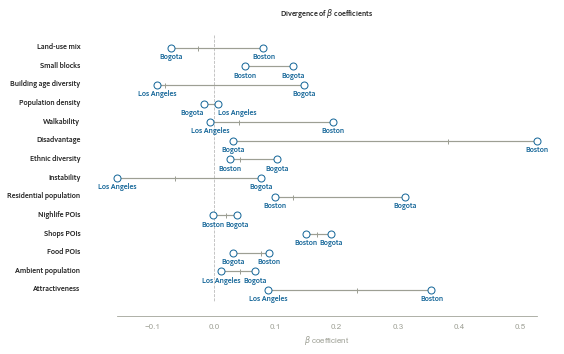

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import font_manager as fm, rcParams
import os

cities = ['bogota', 'boston', 'LA']
percentiles = load_percentiles(cities, 'full')
n_cities = len(cities)


blue_color = np.array([22, 103, 153])/255.
gray_color = np.array([157, 159, 148])/255.

points = np.ones(7)  # Draw 5 points for each line
marker_style = dict(color=gray_color, marker='o',
                    markersize=7, markerfacecoloralt='tab:red', markeredgecolor=blue_color)
marker_style_centrals = dict(color="None", marker='|', markersize=5, markeredgecolor=gray_color, markerfacecolor=gray_color)

fig, ax = plt.subplots(figsize=figsize(1, 0.65))
fig.tight_layout()

fpath_bold = "../data/resources/econsans-subset-cd-md.woff.ttf"
font_bold = fm.FontProperties(fname=fpath_bold)
fpath_light = "../data/resources/econsans-subset-cd-li.woff.ttf"
font_light = fm.FontProperties(fname=fpath_light)

features = jacobs_features + demo_features + core_features + mobility_features

# Plot all fill styles.
position_label = percentiles.min()
for i, beta_values in enumerate(reversed(percentiles)):
    minx = beta_values.min()
    maxx = beta_values.max()
    min_city = nice_city_mapping[cities[beta_values.argmin()]]
    max_city = nice_city_mapping[cities[beta_values.argmax()]]
    
    remaining_indexes = list(set([x for x in range(percentiles.shape[1])]).difference(set([beta_values.argmin(), beta_values.argmax()])))
    
    ax.text(position_label-0.06, len(percentiles)-1-i+0.25, nice_names_mapping[features[i]],
            horizontalalignment='right', verticalalignment='top', fontproperties=font_bold)
    #print(beta_values[remaining_indexes], [i]*(n_cities-2))
    ax.plot(beta_values[remaining_indexes], [i]*(n_cities-2), fillstyle='full', **marker_style_centrals)
    ax.plot([minx, maxx], [i]*(2), fillstyle='full', markerfacecolor='white', **marker_style)
    
    horizontalalignment1='center'
    horizontalalignment2='center'
    if features[len(percentiles)-1-i] in {'density_dwellings'}:
        horizontalalignment1 = 'right'
        horizontalalignment2 = 'left'
    
    plt.text(minx, i-0.6, min_city, fontsize=8, horizontalalignment=horizontalalignment1, color=blue_color, fontproperties=font_bold)
    plt.text(maxx, i-0.6, max_city, fontsize=8, horizontalalignment=horizontalalignment2, color=blue_color, fontproperties=font_bold)


ax.set_title(r'Divergence of $\beta$ coefficients', fontproperties=font_bold)
ax.set_xlabel(r'$\beta$ coefficient')

ax.vlines(0, ax.get_ylim()[1], ax.get_ylim()[0], linewidth=0.8, alpha=0.9, color=np.array([175,175,175])/255., linestyle='--', zorder=0)

#ax.set_axis_off()
plt.gca().axes.get_yaxis().set_visible(False)
ax.xaxis.label.set_color(gray_color)
ax.spines['bottom'].set_color(gray_color)
ax.tick_params(axis='x', colors=gray_color)
ax.spines['bottom'].set_smart_bounds(True) 
ax.spines['bottom'].set_linewidth(0.8)
ax.xaxis.set_ticks_position('none') 

sns.despine(left=True)
plt.savefig("../figures/test.pdf", format='pdf', dpi=200,transparent=True, bbox_inches='tight', pad_inches=0.05)

## Predictions

In [237]:
features

['land_use_mix3',
 'small_blocks',
 'building_diversity2',
 'density_dwellings',
 'core_walkscore',
 'disadvantage',
 'ethnic_diversity',
 'residential_stability',
 'core_population',
 'core_nightlife',
 'core_shops',
 'core_food',
 'core_ambient',
 'attractiveness']

In [262]:
import pickle

from statsmodels.genmod.families.family import NegativeBinomial
import statsmodels.genmod.families.family as family
import statsmodels
from statsmodels.genmod.families import links

def load_eigenfactors(city, model_name, n_factors=4):
    # Load W
    cache_name = '../cache/{city}_ego_W.npz'.format(city=city)
    W = np.load(cache_name)['W']
    
    N = len(W)

    ones = np.ones((N, 1), dtype='float32')
    P_t = np.identity(N, dtype='float32') - ones.dot(ones.T)/N
    M = P_t.dot(W).dot(P_t)

    v, E = np.linalg.eigh(M)
    sortid = v.argsort()[::-1]

    E = E[:, sortid]
    
    E_firstn = E[:, :n_factors]
    
    return E_firstn

def cross_predict(cityfrom, cityto, features, model_type='full'):

    model_name = make_model_name(cityfrom, model_type)
    model_name2 = make_model_name(cityto, model_type)

    # Load phi
    with open('../data/generated_files/pkl/{spatial_model}_{model_name}.pkl'.format(spatial_model='BSF', model_name=model_name), "rb") as f:
        fit = pickle.load(f)['fit']
        phi = fit.extract(permuted=False, inc_warmup=False, pars=['betas', 'phi2', 'phi', 'intercept'])
    with open('../data/generated_files/pkl/{spatial_model}_{model_name}.pkl'.format(spatial_model='BSF', model_name=model_name2), "rb") as f:
        fit = pickle.load(f)['fit']
        phi2 = fit.extract(permuted=False, inc_warmup=False, pars=['phi2'])

    # Input data
    df_input = pd.read_csv('../data/generated_files/merged_features.csv')
    data_df = df_input[df_input.city == cityto].copy()
    X = (data_df[features] - data_df[features].mean()) / data_df[features].std()
    
    E_firstn = load_eigenfactors(cityto, model_name2, n_factors=phi['phi'].shape[-1])
    
    # Model
    nb = NegativeBinomial(alpha=1/phi['phi2'])
    
    fixedE = X.dot(phi['betas'].mean(axis=0)[0, :])
    randomE = E_firstn.dot(phi['phi'].mean(axis=0)[0, :])

    y = nb.fitted(phi['intercept'].mean() + randomE + fixedE)

    varI = np.log(1 + 1/np.mean(data_df['ncrimes']) + 1/phi2['phi2'].mean())
    varF = np.var(fixedE)
    varR = np.var(randomE)
    
    return varI, varF, varR, np.mean(np.abs(y - data_df['ncrimes'].values))

In [263]:
cities = ['boston', 'bogota', 'LA', 'chicago']

for c1 in cities:
    for c2 in cities:
        varI, varF, varR, mae = cross_predict(c1, c2, jacobs_features + demo_features + core_features, model_type='sd_uf')

        print("R2_m", c1, c2, varF / (varF + varR + varI), (varF + varR) / (varF + varR + varI), mae)

R2_m boston boston 0.6598792938933796 0.7147530135568491 9.188203983274446
R2_m boston bogota 0.6449367639306793 0.6950960798356054 32.24961774007146
R2_m boston LA 0.8770807640197367 0.8853023818165066 19.45867982491565
R2_m boston chicago 0.7474441666703928 0.764734307414854 15.078554856062087
R2_m bogota boston 0.7250611516431733 0.8123997157733339 44.84328983249807
R2_m bogota bogota 0.659230617618847 0.7562666090501435 19.962561491605495
R2_m bogota LA 0.8018245143313142 0.8311205532178877 33.514755832712
R2_m bogota chicago 0.8278054057739684 0.8538067839141233 50.1640218734549
R2_m LA boston 0.2996420044185074 0.714444570887688 20.72621486561572
R2_m LA bogota 0.3919653963331588 0.7288287645076383 31.362861759078314
R2_m LA LA 0.5647465634753337 0.7176031837857318 13.569767789773755
R2_m LA chicago 0.43873266747891787 0.6390470384089082 15.400126507609604
R2_m chicago boston 0.47023436181771666 0.7642524826956223 18.8356587485407
R2_m chicago bogota 0.5172033195896365 0.76637301